__BOW, классификатор изображений__

Евгений Борисов <esborisov@sevsu.ru>

---

In [1]:
import numpy as np
import numpy.random as rng
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

## загружаем датасет

UIUC Image Database for Car Detection   
https://cogcomp.seas.upenn.edu/Data/Car/

https://disk.yandex.ru/d/KEZSpmlzTekTgw

In [2]:
from skimage.io import imread

folder_train = 'data/cars/train'

# позитивные примеры
with open(folder_train+'/pos/index.txt','rt') as f: files = f.read()
im_pos = np.stack([ imread(folder_train+'/pos/'+f) for f in files.split('\n') if f ])

# негативные примеры
with open(folder_train+'/neg/index.txt','rt') as f: files = f.read()
im_neg = np.stack([ imread(folder_train+'/neg/'+f) for f in files.split('\n') if f ])

del files

In [3]:
im_pos.shape, im_neg.shape

((550, 40, 100), (500, 40, 100))

In [4]:
n_pos = len(im_pos)
b = int(n_pos*.7)
ii = rng.permutation(n_pos)
im_pos_train = im_pos[:b]
im_pos_test = im_pos[b:]

n_neg = len(im_neg)
b = int(n_neg*.7)
ii = rng.permutation(n_neg)
im_neg_train = im_neg[:b]
im_neg_test = im_neg[b:]

In [5]:
del im_pos
del im_neg
del n_pos
del n_neg
del b

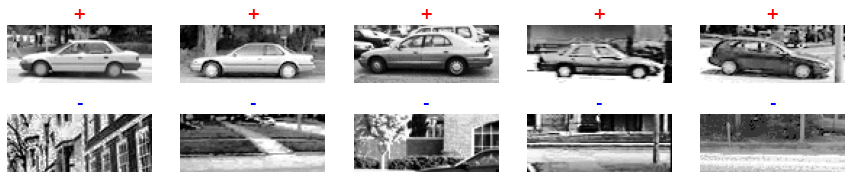

In [6]:
n_show = 5
plt.figure(figsize=(15,3))
ii = rng.permutation(  min( len(im_pos_train),len(im_neg_train) ) )[:n_show]
for n,i in enumerate(ii,start=1 ):
    plt.subplot(2,n_show,n)
    plt.axis(False)
    plt.title('+',color='r',fontdict = {'fontsize':16,'fontweight':'bold'})  
    plt.imshow(im_pos_train[i],cmap='gray')
    
    plt.subplot(2,n_show,n+n_show)
    plt.axis(False)
    plt.title('-',color='b',fontdict = {'fontsize':16,'fontweight':'bold'})  
    plt.imshow(im_neg_train[i],cmap='gray')

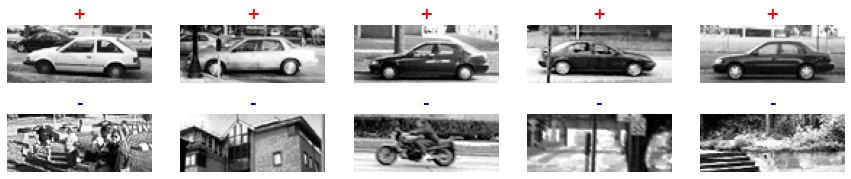

In [7]:
plt.figure(figsize=(15,3))
ii = rng.permutation(  min( len(im_pos_test),len(im_neg_test) ) )[:n_show]
for n,i in enumerate(ii,start=1 ):
    plt.subplot(2,n_show,n)
    plt.axis(False)
    plt.title('+',color='r',fontdict = {'fontsize':16,'fontweight':'bold'})  
    plt.imshow(im_pos_test[i],cmap='gray')
    
    plt.subplot(2,n_show,n+n_show)
    plt.axis(False)
    plt.title('-',color='b',fontdict = {'fontsize':16,'fontweight':'bold'})  
    plt.imshow(im_neg_test[i],cmap='gray')

## строим визуальный словарь

In [9]:
from skimage.feature import ORB
from skimage.feature import SIFT

# descriptor_extractor = ORB(n_keypoints=100)
descriptor_extractor = SIFT()

def extract_descriptors( im, descriptor_extractor=descriptor_extractor ):
    try:
        descriptor_extractor.detect_and_extract(im)
        d = descriptor_extractor.descriptors
        if len(d)<1:
            print('WARNING: no descriptors found')
            d=None
            
    except Exception as e:
        print('WARNING:',e)
        d = None
    return d

In [10]:
descriptors_pos = np.vstack([ 
    d for d in 
    [ extract_descriptors(im) for im in tqdm(im_pos_train) ] 
    if not (d is None) 
])

descriptors_neg = np.vstack([ 
    d for d in 
    [ extract_descriptors(im) for im in tqdm(im_neg_train) ] 
    if not (d is None) 
])

descriptors = np.vstack([descriptors_pos,descriptors_neg])

descriptors.shape

  0%|          | 0/385 [00:00<?, ?it/s]

  0%|          | 0/350 [00:00<?, ?it/s]

(44408, 128)

In [11]:
del descriptors_pos
del descriptors_neg

In [13]:
# descriptors

In [14]:
%%time 

from sklearn.cluster import KMeans

n_clusters = 128
descriptors_labels = KMeans(n_clusters=n_clusters).fit(descriptors).labels_

CPU times: user 3min 19s, sys: 1min 22s, total: 4min 42s
Wall time: 1min 11s


(array([4877., 4611., 4398., 3998., 4702., 4399., 4522., 4307., 4387.,
        4207.]),
 array([  0. ,  12.7,  25.4,  38.1,  50.8,  63.5,  76.2,  88.9, 101.6,
        114.3, 127. ]),
 <BarContainer object of 10 artists>)

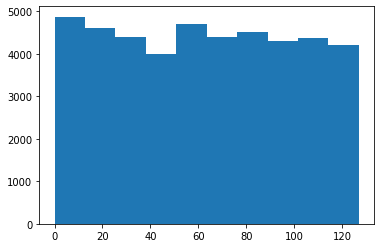

In [15]:
plt.hist( descriptors_labels )

## извлекаем признаки из картинок

In [16]:
# - собираем датасет ( im_pos, im_neg )
# - вынимаем особые точки и их дескрипторы из im_pos
# - кластеризуем дескрипторы
# - для каждого im_pos сосVтавляем список задействованных кластеров
# - ищем соответствия pos дескрипторов в im_neg
# - для каждого im_neg составляем список задействованных кластеров

# вектор-характеристика, 
# длинна равна количеству кластеров,
# в каждой позиции количество обнаруженных дескрипторов кластера

In [17]:
from skimage.feature import match_descriptors

def extract_features(
    im, 
    descriptor_extractor=descriptor_extractor,
    descriptors=descriptors,
    descriptors_labels=descriptors_labels,
    n_clusters=n_clusters,
):
    ds = extract_descriptors(im,descriptor_extractor=descriptor_extractor,)
    if ds is None: return None # return np.zeros(n_clusters,dtype=np.uint16)
    matches = match_descriptors(ds, descriptors)
    if len(matches)<1: return None  # np.zeros(n_clusters,dtype=np.uint16)
    labels = descriptors_labels[ matches[:,1] ]
    return np.eye(n_clusters,dtype=np.uint16)[labels].sum(axis=0,dtype=np.uint16)

### собираем учебный датасет

In [18]:
%%time 

X_pos = np.array([
    f for f in 
    [ extract_features(im) for im in tqdm(im_pos_train) ]
    if not (f is None)
])    

X_neg = np.array([
    f for f in 
    [ extract_features(im) for im in tqdm(im_neg_train) ]
    if not (f is None)
])

X = np.vstack([X_pos,X_neg])
target = [1]*len(X_pos) + [0]*len(X_neg)

  0%|          | 0/385 [00:00<?, ?it/s]

  0%|          | 0/350 [00:00<?, ?it/s]

In [19]:
X.shape

(734, 128)

In [20]:
del X_pos
del X_neg

## обучаем модель

In [21]:
%%time

from sklearn import svm

model = svm.SVC().fit(X,target)

CPU times: user 23 ms, sys: 0 ns, total: 23 ms
Wall time: 22.3 ms


## тестируем модель

### учебный датасет

In [22]:
from sklearn.metrics import classification_report

o = model.predict(X)

print(classification_report(target, o) )

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       349
           1       1.00      0.99      1.00       385

    accuracy                           1.00       734
   macro avg       1.00      1.00      1.00       734
weighted avg       1.00      1.00      1.00       734



### тестовый датасет

In [23]:
%%time 

X_pos = np.array([
    f for f in 
    [ extract_features(im) for im in tqdm(im_pos_test) ]
    if not (f is None)
])   

X_neg = np.array([
    f for f in 
    [ extract_features(im) for im in tqdm(im_neg_test) ]
    if not (f is None)
])  

X = np.vstack([X_pos,X_neg])
target = [1]*len(X_pos) + [0]*len(X_neg)

del X_pos
del X_neg

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

CPU times: user 1min 29s, sys: 827 ms, total: 1min 29s
Wall time: 1min 29s


In [24]:
from sklearn.metrics import classification_report

o = model.predict(X)

print(classification_report(target, o) )

              precision    recall  f1-score   support

           0       0.93      0.85      0.89       150
           1       0.88      0.94      0.91       165

    accuracy                           0.90       315
   macro avg       0.90      0.90      0.90       315
weighted avg       0.90      0.90      0.90       315



---

In [ ]:
# np.histogram(labels,bins=n_clusters)

In [ ]:
# descriptors_pos.shape

In [ ]:
# from skimage.feature import match_descriptors

# match_descriptors?

# matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)

---

In [ ]:
# from skimage.color import rgb2gray
# from skimage import data

# img1 = rgb2gray(data.astronaut())
# img1 = np.floor(img1*250.).astype(np.uint8)

# img1.shape
# plt.imshow(img1)
# descriptor_extractor.detect_and_extract(img1)
# keypoints1 = descriptor_extractor.keypoints
# descriptors1 = descriptor_extractor.descriptors

In [ ]:
# keypoints1
# descriptors1.shape

In [ ]:
# from skimage import data
# from skimage import transform
# from skimage.feature import (match_descriptors, ORB, plot_matches)
# from skimage.color import rgb2gray
# import matplotlib.pyplot as plt


# img1 = rgb2gray(data.astronaut())
# img2 = transform.rotate(img1, 180)
# tform = transform.AffineTransform(scale=(1.3, 1.1), rotation=0.5,
#                                   translation=(0, -200))
# img3 = transform.warp(img1, tform)

# descriptor_extractor = ORB(n_keypoints=200)

# descriptor_extractor.detect_and_extract(img1)
# keypoints1 = descriptor_extractor.keypoints
# descriptors1 = descriptor_extractor.descriptors

# descriptor_extractor.detect_and_extract(img2)
# keypoints2 = descriptor_extractor.keypoints
# descriptors2 = descriptor_extractor.descriptors

# descriptor_extractor.detect_and_extract(img3)
# keypoints3 = descriptor_extractor.keypoints
# descriptors3 = descriptor_extractor.descriptors

# matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)
# matches13 = match_descriptors(descriptors1, descriptors3, cross_check=True)

# fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(16,7))

# plt.gray()

# plot_matches(ax[0], img1, img2, keypoints1, keypoints2, matches12)
# ax[0].axis('off')
# ax[0].set_title("Original Image vs. Transformed Image")

# plot_matches(ax[1], img1, img3, keypoints1, keypoints3, matches13)
# ax[1].axis('off')
# ax[1].set_title("Original Image vs. Transformed Image")


# plt.show()

In [ ]:
# img1 = im_train_pos[1]

# descriptor_extractor.detect_and_extract(img1)

# keypoints1 = descriptor_extractor.keypoints
# descriptors1 = descriptor_extractor.descriptors

# keypoints1
# # descriptors1

---

In [ ]:
# !wget -c http://cs231n.stanford.edu/tiny-imagenet-200.zip

---

In [ ]:
# from tensorflow.keras.datasets import fashion_mnist
# (image_train, target_train),(image_test, target_test) = fashion_mnist.load_data()
# image_train.shape, image_test.shape

In [ ]:
# n_show, ppc, cpb = 9, (8,8), (2,2) # pixels per cell, cells per block

# plt.figure(figsize=(16,4))
# for n,i in enumerate(rng.permutation(len(image_train))[:n_show], start=1):
#     img = image_train[i]
#     plt.subplot(1,n_show,n)
#     plt.axis(False)
#     plt.imshow(img,cmap='gray_r')

# #     _,hog_img = hog(img,pixels_per_cell=ppc,cells_per_block=cpb,visualize=True,)
# #     plt.subplot( 2, n_show, n+n_show)
# #     plt.axis(False)
# #     plt.imshow(hog_img) #,cmap='gray_r')

---